In [1]:
import sys
sys.path.append('../')

In this notebook we prepare eROSITA catalog in pandas format for loading into NWAY (which demands fits file)

In [2]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import cat2hpx, pandas_to_fits, my_scaler_forward, cross_match_data_frames
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import healpy as hp
%matplotlib inline


matplotlib settings set


matplotlib settings set
This is NWAY Python API
nwaylib file /Users/sdbykov/work/my_packages/nway/nwaylib/__init__.py


# LH X-ray catalog

little work with X-ray catalog was done boforehand: duplicates  and extended sources removal

Read catalog and create a fits table with positions and positional errors

In [3]:
xcat_orig = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
positional_error_columns = 'pos_sigma_2d'
print('*'*50)
print('using positional error columns:', positional_error_columns)


columns_to_retain = ['srcname_fin', 'RA_fin', 'DEC_fin', positional_error_columns, 'ML_FLUX_0'] 


xcat = xcat_orig[xcat_orig['DET_LIKE_0']>6]
xcat = xcat[columns_to_retain]
xcat[positional_error_columns] = xcat[positional_error_columns]

xcat.rename(columns={'RA_fin':'RA', 'DEC_fin':'DEC', positional_error_columns:'pos_err', 'srcname_fin': 'ID'}, inplace=True)


print('using corrected positional error columns: 1*', positional_error_columns)
print('*'*50)

xcat['pos_err'] = xcat['pos_err']

**************************************************
using positional error columns: pos_sigma_2d
using corrected positional error columns: 1* pos_sigma_2d
**************************************************


## area and plotting

Resolution of the HEALPix map:
0.05725810686362343 deg per pixel, or
3.435486411817406 arcmin per pixel, or
206.12918470904435 arcsec per pixel
15.241703736666857 sq. deg.


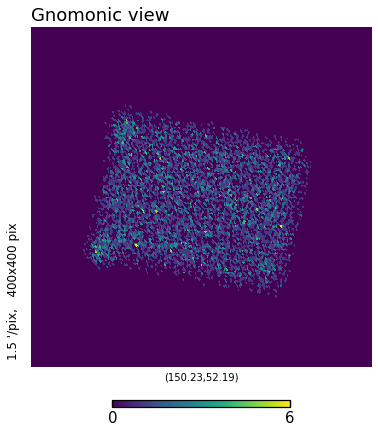

In [5]:
xcat_hp_map = cat2hpx(xcat['RA'], xcat['DEC'], nside=1024, radec=True)
hp.gnomview(xcat_hp_map, rot = [150.23,52.19], xsize = 400)

ERO_SKYAREA = 4*np.pi*(np.rad2deg(1))**2 * np.sum(xcat_hp_map>=1)/len(xcat_hp_map)
print(ERO_SKYAREA, 'sq. deg.')

In [6]:
pandas_to_fits(dataframe = xcat, 
                filename = 'ERO_lhpv_03_23_sd01_a15_g14.fits',
                table_header_name = 'eROSITA',
                sky_area_deg2 = ERO_SKYAREA)

In [7]:
xcat[['RA', 'DEC']].describe().loc[['min', 'max']]

,RA,DEC
min,154.763934,54.124219
max,167.084550,61.209723
